# Stochastic Neural network from scratch
This notebook implements stochastic deep learning with Monte Carlo Methods

## Import general library and define common structure

In [2]:
# Import library and set up environment
import os as os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)

cuda
Number of GPU workers available: 2


In [4]:
# Create a class that aid in training and testing
class Model_Wrapper:
    def __init__(self, model, optimizer, loss_function, device):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_train_epoch = 0
        self.train_loss_list = []
        self.calculated_metrics = None

    def push_to_device(self):
        self.model = self.model.to(self.device)
        self.loss_function = self.loss_function.to(self.device)

    def train(self, num_epochs, train_loader):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (data, labels) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                data = data.to(self.device)
                labels = labels.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                output = self.model(data)
                # Calculate the loss
                loss = self.loss_function(output, labels)
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % 50 == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(labels)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, ax = plt.subplots()
        ax.plot(range(len(self.train_loss_list)), self.train_loss_list)
        # Add a title and labels
        ax.set_title(plot_title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')

    def test(self, test_loader):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (data, labels) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            data = data.to(device)
            labels = labels.to(device)
            # Predict
            output = self.model(data)
            # Calculate the loss
            loss = self.loss_function(output, labels)
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(labels, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def calculate_metrics(self, labels, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        _, y_pred = torch.max(output, 1)
        y_true = labels.data.cpu().numpy()
        y_pred = y_pred.data.cpu().numpy()
        if (self.calculated_metrics == None):
            self.calculated_metrics = {
                "accuracy": [],
                "f1": [],
                "precision": [],
                "recall": []
            }
        self.calculated_metrics["accuracy"].append(accuracy_score(y_true, y_pred))
        self.calculated_metrics["f1"].append(f1_score(y_true, y_pred, average='macro'))
        self.calculated_metrics["precision"].append(precision_score(y_true, y_pred, average='macro', zero_division=1))
        self.calculated_metrics["recall"].append(recall_score(y_true, y_pred, average='macro', zero_division=1))

In [5]:
# Load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])
training = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=32, shuffle=True, num_workers=2)
# Create dataloader
testing = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=32, shuffle=False, num_workers=2)
# Label the classes
classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34724324.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1063582.75it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10313605.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3104208.70it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Monte Carlo approach

In [ ]:
# Define my own drop out layer
class my_drop_out(nn.Module):
    def __init__ (self, dropout_prob = 0.5):
      super(my_drop_out, self).__init__()
      self.dropout_prob = dropout_prob
    def forward(self, x):
      return x*torch.bernoulli(torch.full(x.size(), 1 - self.dropout_prob)).to(device)


In [ ]:
# Define a resnet with dropout
class Monte_Carlo_Stochastic_Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Monte_Carlo_Stochastic_Net, self).__init__()
        # Three conv layer with max pool and then flatten it
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        # Drop out layer for monte carlo sampling
        self.mydropout = my_drop_out()
    def forward(self, x):
        x = self.conv1(x)
        x = self.mydropout(x)
        x = self.conv2(x)
        x = self.mydropout(x)
        x = self.conv3(x)
        x = self.mydropout(x)
        return self.classifier(x)

In [ ]:
# Declare network, loss function, and optimizer
mynet = Monte_Carlo_Stochastic_Net()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net = Model_Wrapper(mynet, optimizer, loss_fun, device)
net.push_to_device()

In [ ]:
net.train(3, train_loader)

Epoch: 2/4; Data 0/60000; Loss: 0.3043586313724518

Epoch: 2/4; Data 1600/60000; Loss: 0.46937939524650574

Epoch: 2/4; Data 3200/60000; Loss: 0.174112930893898

Epoch: 2/4; Data 4800/60000; Loss: 0.7454092502593994

Epoch: 2/4; Data 6400/60000; Loss: 0.17250771820545197

Epoch: 2/4; Data 8000/60000; Loss: 0.4841204285621643

Epoch: 2/4; Data 9600/60000; Loss: 0.3721995949745178

Epoch: 2/4; Data 11200/60000; Loss: 0.4814663529396057

Epoch: 2/4; Data 12800/60000; Loss: 0.3901425004005432

Epoch: 2/4; Data 14400/60000; Loss: 0.24258966743946075

Epoch: 2/4; Data 16000/60000; Loss: 0.43834972381591797

Epoch: 2/4; Data 17600/60000; Loss: 0.5091031193733215

Epoch: 2/4; Data 19200/60000; Loss: 0.28112950921058655

Epoch: 2/4; Data 20800/60000; Loss: 0.23795408010482788

Epoch: 2/4; Data 22400/60000; Loss: 0.1967105269432068

Epoch: 2/4; Data 24000/60000; Loss: 0.37127482891082764

Epoch: 2/4; Data 25600/60000; Loss: 0.3457716107368469

Epoch: 2/4; Data 27200/60000; Loss: 0.18181028962135

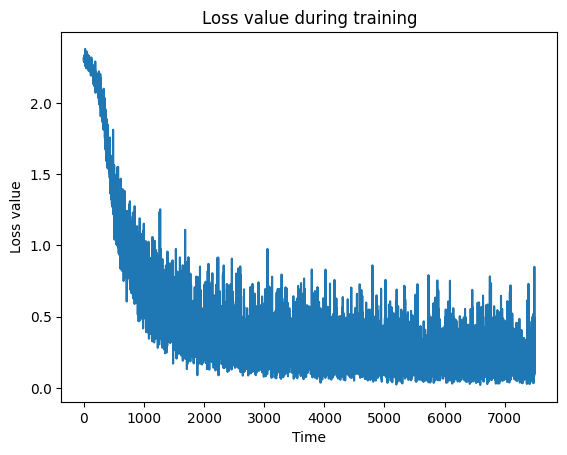

In [ ]:
net.plot_train_loss()

In [ ]:
net.test(test_loader)

Loss: 0.1712

accuracy: 0.9456

f1: 0.9325

precision: 0.9471

recall: 0.9462


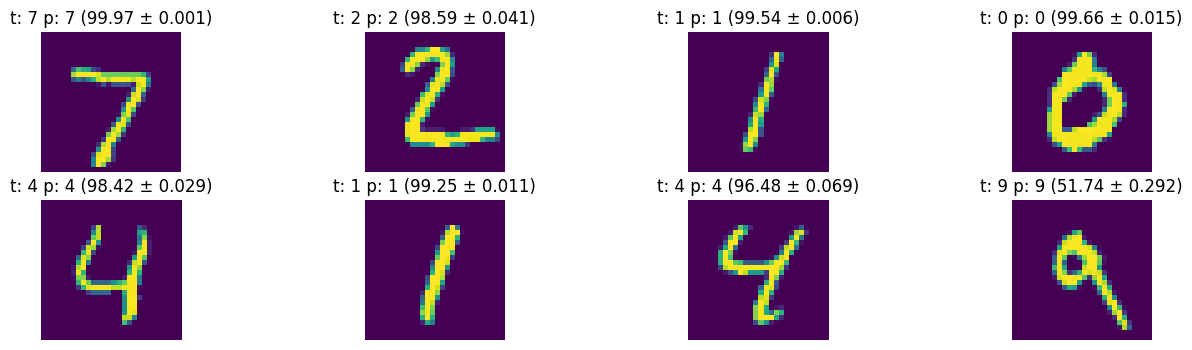

In [ ]:
# Plot one prediction the probability of prediction and its std
# Number of rows and column to show
rows = 2
columns = 4
number_of_items = rows*columns
# Make an iterator from test_loader
test_iterator = iter(test_loader)
# Get a batch of testing images
images, labels = next(test_iterator)
# Get only necessary items
images = images[0:number_of_items]
labels = labels[0:number_of_items]
# Push data to device
images = images.to(device)
# Run the model 1000 time to get multiple prediction
predict = []
for i in range(1000):
    predict.append(F.softmax(net.model(images), dim = 1).cpu().detach())
predict = torch.stack(predict, dim = 0)
predict_mean = predict.mean(dim = 0)
predict_std = predict.std(dim = 0)
# Get predicted class from the class probabilities
y_value, y_pred = torch.max(predict_mean, 1)
# Plot results
# plot y_score - true label (t) vs predicted label (p)
fig = plt.figure(figsize=(16,4))
y_pred = y_pred.cpu()
y_value = y_value.tolist()
predict_std = predict_std.tolist()

for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(f"t: {classes[labels[i]]} p: {classes[y_pred[i]]} ({round(y_value[i]*100, 2)} ± {round(predict_std[i][y_pred[i]],3)})")
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()

# Variational inference approach (NOT YET FINISHED)
https://arxiv.org/pdf/1505.05424.pdf

## I some what messed up the Math, which is why it didn't work. I'll comeback later.

In [6]:
def gaussian_diag_log(values, means, covariances):
    """
    Calculates the probability density function (PDF) of a diagonal multi-variate Gaussian distribution
    """
    values = values.flatten()
    means = means.flatten()
    covariances = covariances.flatten()
    result = torch.log(1/torch.sqrt((2*torch.pi)**len(values)*covariances.prod()))
    result += (-1/2*(values-means)**2/covariances).sum()
    return result/len(values)

a = torch.rand(5)
b = torch.rand(5)
c = torch.rand(5)
print(gaussian_diag_log(a, b, c))

def gaussian_diag_log(values, means, covariances = torch.tensor([1])):
    """
    Calculates the probability density function (PDF) of a diagonal multi-variate Gaussian distribution
    """
    values = values.flatten()
    means = means.flatten()
    covariances = covariances.flatten()
    result = 1/2*torch.log(torch.tensor(1/(2*torch.pi))) - 1/2*torch.log(covariances).sum()/len(values)
    result += (-1/2*(values-means)**2/covariances).mean()
    return result

print(gaussian_diag_log(a, b, c))
print(gaussian_diag_log(a.to(device), b.to(device), c.to(device)))


tensor(-0.4777)
tensor(-0.4777)
tensor(-0.4777, device='cuda:0')


In [7]:
# This code is adapted from my lecture by Jorge Cardoso at King's College London
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, gaussian_prior = torch.tensor([0, 1])):
        super(BayesLinear_Normalq, self).__init__()
        # Store some variables
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = nn.Parameter(gaussian_prior, requires_grad=False)

        # Initialise the MUs weights and biases as a uniform(-0.05,0.05) and
        # the RHOs weights and biases as a uniform(-2,-1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))

    def forward(self, x, sample = True):
        if sample:
            # Sample gaussian noise for the parameters (weight and bias)
            weight_epsilons = (self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons = (self.bias_mus.data.new(self.bias_mus.size()).normal_())
            # Calculate the parameter stds from the rho parameters
            weight_stds = torch.log(1+torch.exp(self.weight_rhos))
            bias_stds = torch.log(1+torch.exp(self.bias_rhos))
            # Calculate the sampled parameters
            weight_sample = self.weight_mus + weight_stds*weight_epsilons
            bias_sample = self.bias_mus + bias_stds*bias_epsilons
        else:
            # Calculate the parameter stds from the rho parameters
            weight_stds = torch.log(1+torch.exp(self.weight_rhos))
            bias_stds = torch.log(1+torch.exp(self.bias_rhos))
            # Calculate the sampled parameters
            weight_sample = self.weight_mus
            bias_sample = self.bias_mus

        output = x@weight_sample + bias_sample #YOUR CODE HERE

        # Computing the KL loss term for the weights
        # Calculate log q(w|θ)
        KL_loss = gaussian_diag_log(weight_sample, self.weight_mus, weight_stds**2)
        # Calculate −log P(w)
        KL_loss += -gaussian_diag_log(weight_sample, self.prior[0], self.prior[1])

        # Computing the KL loss term for the biases
        # Calculate log q(w|θ)
        KL_loss += gaussian_diag_log(bias_sample, self.bias_mus, bias_stds**2)
        # Calculate −log P(w)
        KL_loss += -gaussian_diag_log(bias_sample, self.prior[0], self.prior[1])

        return output, KL_loss

In [8]:
# Define a net where linear layer are replace with bayesian weight
class Back_Prop_Stochastic_Net(nn.Module):
    def __init__(self, num_classes=10, output_std = torch.tensor([1.0])):
        super(Back_Prop_Stochastic_Net, self).__init__()
        # Three conv layer with max pool and then flatten it
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.baye_linear_1 = BayesLinear_Normalq(64 * 3 * 3, 64)
        self.baye_linear_2 = BayesLinear_Normalq(64, num_classes)
        self.output_std = nn.Parameter(output_std)
    def forward(self, x):
        KL_loss_total = 0
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, start_dim=1)
        x, KL_loss = self.baye_linear_1(x)
        KL_loss_total += KL_loss
        x = F.relu(x)
        x, KL_loss = self.baye_linear_2(x)
        KL_loss_total += KL_loss
        return x, KL_loss_total

image = next(iter(train_loader))[0].to(device)
test = Back_Prop_Stochastic_Net().to(device)
test(image)[0].size()


torch.Size([32, 10])

In [9]:
# Create a class that aid in training and testing
class Model_Wrapper_2:
    def __init__(self, model, optimizer, loss_function, device):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_train_epoch = 0
        self.train_loss_list = []
        self.calculated_metrics = None

    def push_to_device(self):
        self.model = self.model.to(self.device)
        # self.loss_function = self.loss_function.to(self.device)

    def train(self, num_epochs, train_loader):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (data, labels) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                data = data.to(self.device)
                labels = labels.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                output, KL_loss = self.model(data)
                # Calculate the loss
                labels = F.one_hot(labels, num_classes=10)
                loss = -self.loss_function(labels, output, self.model.output_std) + KL_loss
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % 50 == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(labels)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, ax = plt.subplots()
        ax.plot(range(len(self.train_loss_list)), self.train_loss_list)
        # Add a title and labels
        ax.set_title(plot_title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')

    def test(self, test_loader):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (data, labels) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            data = data.to(device)
            labels = labels.to(device)
            # Predict
            output, KL_loss = self.model(data)
            # Calculate the loss
            labels = F.one_hot(labels, num_classes=10)
            loss = -self.loss_function(labels, output, self.model.output_std) + KL_loss
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(labels, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def calculate_metrics(self, labels, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        _, labels = torch.max(labels, 1)
        _, y_pred = torch.max(output, 1)
        y_true = labels.data.cpu().numpy()
        y_pred = y_pred.data.cpu().numpy()
        if (self.calculated_metrics == None):
            self.calculated_metrics = {
                "accuracy": [],
                "f1": [],
                "precision": [],
                "recall": []
            }
        self.calculated_metrics["accuracy"].append(accuracy_score(y_true, y_pred))
        self.calculated_metrics["f1"].append(f1_score(y_true, y_pred, average='macro'))
        self.calculated_metrics["precision"].append(precision_score(y_true, y_pred, average='macro', zero_division=1))
        self.calculated_metrics["recall"].append(recall_score(y_true, y_pred, average='macro', zero_division=1))

In [12]:
# Declare network, loss function, and optimizer
mynet2 = Back_Prop_Stochastic_Net(10, torch.tensor(0.1))
negative_loss_fun = gaussian_diag_log
optimizer = optim.Adam(mynet2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [13]:
net2 = Model_Wrapper_2(mynet2, optimizer, negative_loss_fun, device)
net2.push_to_device()

In [14]:
net2.train(10, train_loader)

Epoch: 1/10; Data 0/60000; Loss: 203.52845764160156
Epoch: 1/10; Data 1600/60000; Loss: 38.12907791137695
Epoch: 1/10; Data 3200/60000; Loss: 16.483299255371094
Epoch: 1/10; Data 4800/60000; Loss: 10.16659164428711
Epoch: 1/10; Data 6400/60000; Loss: 10.403865814208984
Epoch: 1/10; Data 8000/60000; Loss: 6.555479049682617
Epoch: 1/10; Data 9600/60000; Loss: 6.752651214599609
Epoch: 1/10; Data 11200/60000; Loss: 5.65283203125
Epoch: 1/10; Data 12800/60000; Loss: 5.962087154388428
Epoch: 1/10; Data 14400/60000; Loss: 6.057250022888184
Epoch: 1/10; Data 16000/60000; Loss: 5.880273342132568
Epoch: 1/10; Data 17600/60000; Loss: 6.144803047180176
Epoch: 1/10; Data 19200/60000; Loss: 6.149575233459473
Epoch: 1/10; Data 20800/60000; Loss: 6.498549938201904
Epoch: 1/10; Data 22400/60000; Loss: 6.339346885681152
Epoch: 1/10; Data 24000/60000; Loss: 5.725200653076172
Epoch: 1/10; Data 25600/60000; Loss: 5.506305694580078
Epoch: 1/10; Data 27200/60000; Loss: 5.885370254516602
Epoch: 1/10; Data 288

(0.0, 10.0)

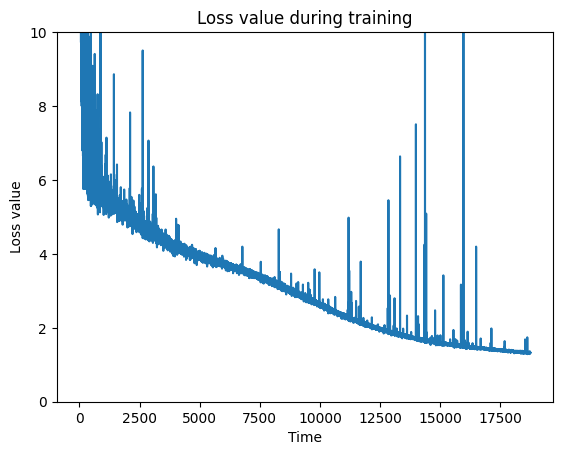

In [15]:
net2.plot_train_loss()
plt.ylim(0, 10)

In [20]:
net2.test(test_loader)

KeyboardInterrupt: 

In [21]:
# Plot one prediction the probability of prediction and its std
# Number of rows and column to show
rows = 2
columns = 4
number_of_items = rows*columns
# Make an iterator from test_loader
test_iterator = iter(test_loader)
# Get a batch of testing images
images, labels = next(test_iterator)
# Get only necessary items
images = images[0:number_of_items]
labels = labels[0:number_of_items]
# Push data to device
images = images.to(device)
# Run the model 1000 time to get multiple prediction
predict = []
for i in range(1000):
    predict.append(F.softmax(net2.model(images)[0], dim = 1).cpu().detach())
predict = torch.stack(predict, dim = 0)
predict_mean = predict.mean(dim = 0)
predict_std = predict.std(dim = 0)
# Get predicted class from the class probabilities
y_value, y_pred = torch.max(predict_mean, 1)
# Plot results
# plot y_score - true label (t) vs predicted label (p)
fig = plt.figure(figsize=(16,4))
y_pred = y_pred.cpu()
y_value = y_value.tolist()
predict_std = predict_std.tolist()

for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.title(f"t: {classes[labels[i]]} p: {classes[y_pred[i]]} ({round(y_value[i]*100, 2)} ± {round(predict_std[i][y_pred[i]],3)})")
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()

KeyboardInterrupt: 

## I couldn't make this work. The problem might lie in the loss function.